## Libraries

In [120]:
import pandas as pd
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import streamlit as st
import ipywidgets as widgets
import re
from sklearn.cluster import KMeans
from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from scipy.spatial import distance
from tqdm import tqdm
from pathlib import Path
from soccerplots.radar_chart import Radar
from mplsoccer import PyPizza, add_image, FontManager
from highlight_text import fig_text
from bokeh.plotting import figure, show, output_file, save
from bokeh.io import output_notebook
import warnings
import yaml
warnings.filterwarnings("ignore")

### Download Fonts

In [121]:
# Doenload specifc fonts from github
font_normal = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto%5Bwdth,wght%5D.ttf')
font_italic = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/roboto/'
                          'Roboto-Italic%5Bwdth,wght%5D.ttf')
font_bold = FontManager('https://raw.githubusercontent.com/google/fonts/main/apache/robotoslab/'
                        'RobotoSlab%5Bwght%5D.ttf')

## Import Data

Using static data extracted from Wyscout (API access is needed to retrieve up-to-date data).

Players and metrics in dataset:
- 2021/22 season 
- top 5 European Leagues
- Centre-Midfield/Centre Attacking Midfield

In [122]:
# Read both excel files
df1 = pd.read_excel('cb_players.xlsx')
df2 = pd.read_excel('cf_players.xlsx')
df3 = pd.read_excel('cm_players1.xlsx')
df4 = pd.read_excel('cm_players2.xlsx')
df5 = pd.read_excel('fb_players.xlsx')
df6 = pd.read_excel('wing_players1.xlsx')
df7 = pd.read_excel('wing_players2.xlsx')


In [123]:
# Add a column for the players first position
df1['Position1'] = 'CB'
df2['Position1'] = 'CF'
df3['Position1'] = 'CM'
df4['Position1'] = 'CM'
df5['Position1'] = 'FB'
df6['Position1'] = 'W'
df7['Position1'] = 'W'

In [124]:
# Concatonate both files together
df = pd.concat([df1,df2,df3,df4,df5,df6,df7])

# Fill gaps with 0 value
df = df.fillna(0)

# Exclude players with insuffiencient minutes
df = df.loc[df["Minutes played"]>400]

# Elimate duplicates
df = df.reset_index(drop=True)
df = df.reset_index()

In [125]:
df

,index,Player,Team,Team within selected timeframe,Position,Age,Market value,Contract expires,Matches played,Minutes played,...,Back passes received as GK per 90,Exits per 90,Aerial duels per 90.1,Free kicks per 90,Direct free kicks per 90,"Direct free kicks on target, %",Corners per 90,Penalties taken,"Penalty conversion, %",Position1
0,0,Rúben Dias,Manchester City,Manchester City,RCB,25,75000000,2027-06-30,29,2594,...,2.19,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,CB
1,1,M. de Ligt,Bayern München,Juventus,"RCB, LCB",22,70000000,2027-06-30,31,2869,...,1.47,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,CB
2,2,Marquinhos,PSG,PSG,RCB,28,70000000,2024-06-30,32,3044,...,1.33,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,CB
3,3,M. Škriniar,Internazionale,Internazionale,"RCB, CB",27,65000000,2023-06-30,35,3378,...,2.29,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,CB
4,4,W. Fofana,Chelsea,Leicester City,"RCB, CB",21,65000000,2029-06-30,7,683,...,2.50,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,CB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,1927,C. Ansaldi,Parma,Torino,LWB,36,700000,2023-06-30,19,796,...,0.45,0.0,0.0,0.45,0.0,0.0,1.13,0,0.0,W
1928,1928,B. Oczipka,Arminia Bielefeld,Union Berlin,"LB, LWB",33,600000,0,18,995,...,0.63,0.0,0.0,1.18,0.0,0.0,1.72,0,0.0,W
1929,1929,A. Bamba,Angers SCO,Angers SCO,"RWB, RB",32,500000,2023-06-30,10,501,...,0.18,0.0,0.0,0.00,0.0,0.0,0.00,0,0.0,W
1930,1930,D. Brosinski,0,Mainz 05,"RWB, RB",34,300000,0,11,429,...,1.05,0.0,0.0,0.42,0.0,0.0,1.26,0,0.0,W


In [126]:
df.to_csv('metrics_df.csv')

In [127]:
# Create player ID dictionary
players =[]
for idx in range(len(df)):
    players.append(df['Player'][idx] + ' ({})'.format(df['Team within selected timeframe'][idx]))

player_ID = dict(zip(players, np.arange(len(players))))

## Player Similarity

In [128]:
# selecting only numerical metrics
stats = df.drop(['Birth country','Passport country','Foot','Height','Weight','On loan'], axis=1)
stats = stats.iloc[:, 10:-1]

T-Distributed Stochastic Neigbor Embedding (t-SNE)
- Used to visualise high dimensional data (lots of metrics) for data exploration.
- Converts all features (metrics) into 2 dimensions.
- Similar players will be grouped in the same clusters.
- Similarity is defined by the conditional probability that datapoint 1 (player 1) would pick datapoint 2 (player 2) as its neighbor.
- The term 'neihbors' refers to the set of points which are closest to each point.
- It works by mapping onto 2D space and minimising the difference between the two distributions over all points (metrics).

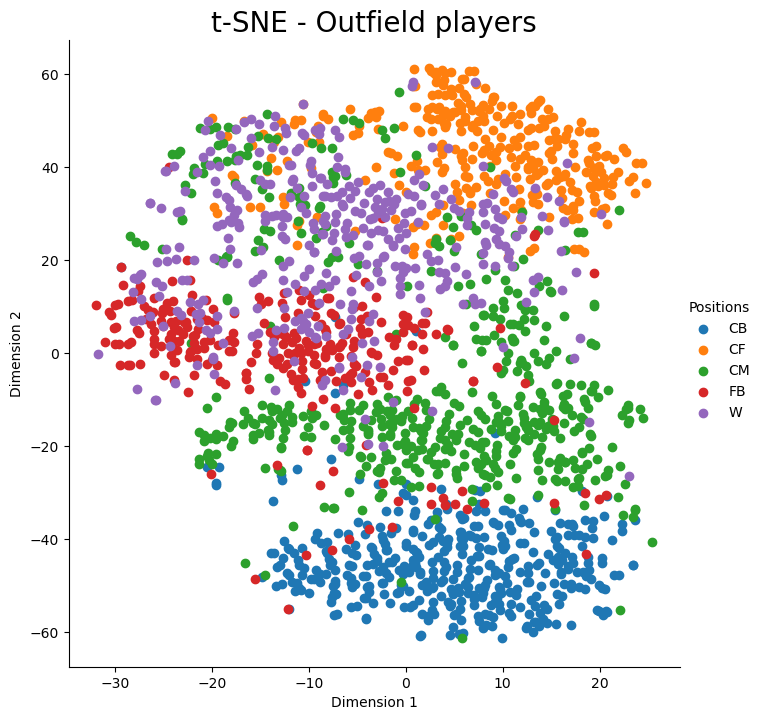

In [129]:
# position types
labels = df['Position1']

# standardizing the data
data = StandardScaler().fit_transform(stats)

# configuring tSNE params
model = TSNE(n_components=2, perplexity=30, random_state=0)
tsne_data = model.fit_transform(data)

# creating a new df to plot the result data
tsne_data = np.vstack((tsne_data.T, labels)).T
tsne_df = pd.DataFrame(data=tsne_data, columns=("Dimension 1", "Dimension 2", "Positions"))

# ploting the result of tSNE
ax = sns.FacetGrid(tsne_df, hue="Positions", size=7)\
        .map(plt.scatter, 'Dimension 1', 'Dimension 2').add_legend()
plt.title('t-SNE - Outfield players', size=20)
plt.show()

Principle Component Analysis (PCA)
- Used to redcue the dimentionality of ther dataset by transforming the data into a new coordinate system.
- Most of the variation (between players) csn be described with fewer dimensions (metrics) than the initial dataset.

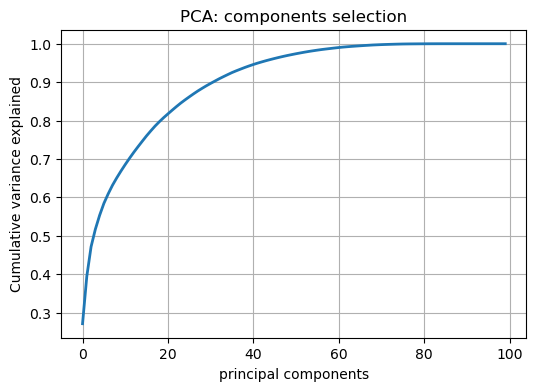

In [130]:
# Counting number of metrics
no_of_metrics = stats.shape[1]

# standardizing the data
data = StandardScaler().fit_transform(stats)

# setting up and running PCA
pca = decomposition.PCA()
pca.n_components = no_of_metrics
pca_data = pca.fit_transform(data)

# % variance explained per components
percentage_var_explained = pca.explained_variance_ / np.sum(pca.explained_variance_);

# cumulative variance explained
cum_var_explained = np.cumsum(percentage_var_explained)

plt.figure(1, figsize=(6, 4))
plt.plot(cum_var_explained, linewidth=2)
plt.axis('tight')
plt.grid()
plt.xlabel('principal components')
plt.ylabel('Cumulative variance explained')
plt.title('PCA: components selection')
plt.show()

In [131]:
# Cut the number of metrics down to the first 70 components out of 100 (i.e., select the first 70 principal components found in the new coordinate system)
stats = pca_data[:, :70]

In [132]:
# fetch the player vector
def getStats(name):
    idx = player_ID[name]
    return stats[idx, :]

# fetch cosine similarity between two player vectors
def similarity(player1, player2):
    return 1 - distance.cosine(getStats(player1), getStats(player2))

# normalize an array to a scale of 0 to 100
def normalize(array):
    return np.array([round(num, 2) for num in (array - min(array))*100/(max(array)-min(array))])

# player-similarities hash table
engine = {}
for query in tqdm(players):
    metric = []
    for player in players:
        value = similarity(query, player)
        metric.append(value)
    metric = normalize(metric)
    # adding normalized similarity values to the 'player name' key
    engine[query] = metric

# saving hash table/dict as a pickle
with open(r'data\engine.pickle', 'wb') as file:
    pickle.dump(engine, file)

100%|██████████| 1932/1932 [01:42<00:00, 18.88it/s]


### Exploring results

In [133]:
# Convert into pandas df
similarity_df = pd.DataFrame(data=engine)

# Merge on index and set to Player_ID
similarity_df = similarity_df.reset_index()
similarity_df = similarity_df.merge(df[['index','Player']], on='index', how='inner')
similarity_df = similarity_df.drop('index',axis=1)

# Move Players column to the front
cols = similarity_df.columns.tolist()
cols = cols[-1:] + cols[:-1]
similarity_df = similarity_df[cols]

In [134]:
# Rename all columns headers to remove squad name
similarity_df.columns = similarity_df.columns.str.replace(r"\(.*\)","")
similarity_df = similarity_df.rename(columns = lambda x : str(x)[:-1])
similarity_df = similarity_df.rename(columns = {'Playe':'Player'})

In [135]:
similarity_df

,Player,Rúben Dias,M. de Ligt,Marquinhos,M. Škriniar,W. Fofana,J. Koundé,A. Bastoni,Éder Militão,R. Araújo,...,J. Pastore,Bebé,Nolito,D. Caligiuri,D. Liénard,C. Ansaldi,B. Oczipka,A. Bamba,D. Brosinski,J. Faussurier
0,Rúben Dias,100.00,81.85,83.84,80.71,77.98,78.42,85.82,77.09,78.51,...,24.20,6.51,12.18,5.77,27.04,23.72,19.74,18.00,36.37,11.01
1,M. de Ligt,80.76,100.00,81.54,81.82,73.21,83.22,68.29,77.13,80.88,...,11.83,0.01,13.64,4.41,11.57,9.32,16.09,19.34,23.85,7.78
2,Marquinhos,83.48,82.20,100.00,86.23,70.66,78.52,75.99,87.55,82.25,...,25.48,5.34,19.39,6.48,17.07,13.84,16.98,23.34,27.44,12.81
3,M. Škriniar,80.71,82.86,86.54,100.00,71.23,77.81,75.78,82.40,86.85,...,12.57,3.33,13.87,0.00,12.27,6.53,14.91,29.59,29.36,5.29
4,W. Fofana,77.58,74.27,70.79,70.70,100.00,69.82,73.21,82.04,62.94,...,11.97,12.68,3.39,15.34,25.80,14.15,25.77,37.57,29.70,8.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,C. Ansaldi,31.20,22.86,23.98,15.69,23.94,26.94,36.51,21.48,27.04,...,47.81,51.82,32.40,42.58,78.55,100.00,68.79,22.12,51.57,62.65
1928,B. Oczipka,29.67,30.65,28.84,25.42,36.10,34.47,41.56,37.55,32.22,...,39.47,41.49,30.27,45.59,69.05,69.68,100.00,37.99,48.73,42.66
1929,A. Bamba,24.58,30.02,31.02,35.22,43.59,31.86,32.69,41.60,24.92,...,29.24,31.96,26.26,24.13,22.63,20.57,34.92,100.00,49.54,38.79
1930,D. Brosinski,41.67,34.16,34.93,35.23,36.69,45.17,52.05,38.97,31.88,...,39.37,45.05,24.23,27.80,50.24,50.78,46.36,49.70,100.00,65.38


In [136]:
similarity_df.to_csv('similarity_df.csv')

## Interactive Player Comparison

In [137]:
#options = similarity_df['Player'].unique()
options = similarity_df.columns.unique()
options = options.sort_values(ascending=True)
options = options.tolist()
options[0] = 'All'

options = [x for x in options if str(x) != 'nan']
playerlist = widgets.Dropdown(
    options=options,
    value='All',
    description='Player:',
    ensure_option=True,
    disabled=False
)

# filter data for player selected in dropdown
def player_select(player):
    if player == 'All':
        player_df = similarity_df
    else:
        player_df = similarity_df[['Player',player]].sort_values(player, ascending=False)
    return player_df
    
playerlist

Dropdown(description='Player:', options=('All', 'A. Ahmedhodzic', 'A. Andrade', 'A. Aouchiche', 'A. Armstrong'…

In [138]:
player_df = player_select(playerlist.value)
player_df

,Player,Rúben Dias,M. de Ligt,Marquinhos,M. Škriniar,W. Fofana,J. Koundé,A. Bastoni,Éder Militão,R. Araújo,...,J. Pastore,Bebé,Nolito,D. Caligiuri,D. Liénard,C. Ansaldi,B. Oczipka,A. Bamba,D. Brosinski,J. Faussurier
0,Rúben Dias,100.00,81.85,83.84,80.71,77.98,78.42,85.82,77.09,78.51,...,24.20,6.51,12.18,5.77,27.04,23.72,19.74,18.00,36.37,11.01
1,M. de Ligt,80.76,100.00,81.54,81.82,73.21,83.22,68.29,77.13,80.88,...,11.83,0.01,13.64,4.41,11.57,9.32,16.09,19.34,23.85,7.78
2,Marquinhos,83.48,82.20,100.00,86.23,70.66,78.52,75.99,87.55,82.25,...,25.48,5.34,19.39,6.48,17.07,13.84,16.98,23.34,27.44,12.81
3,M. Škriniar,80.71,82.86,86.54,100.00,71.23,77.81,75.78,82.40,86.85,...,12.57,3.33,13.87,0.00,12.27,6.53,14.91,29.59,29.36,5.29
4,W. Fofana,77.58,74.27,70.79,70.70,100.00,69.82,73.21,82.04,62.94,...,11.97,12.68,3.39,15.34,25.80,14.15,25.77,37.57,29.70,8.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1927,C. Ansaldi,31.20,22.86,23.98,15.69,23.94,26.94,36.51,21.48,27.04,...,47.81,51.82,32.40,42.58,78.55,100.00,68.79,22.12,51.57,62.65
1928,B. Oczipka,29.67,30.65,28.84,25.42,36.10,34.47,41.56,37.55,32.22,...,39.47,41.49,30.27,45.59,69.05,69.68,100.00,37.99,48.73,42.66
1929,A. Bamba,24.58,30.02,31.02,35.22,43.59,31.86,32.69,41.60,24.92,...,29.24,31.96,26.26,24.13,22.63,20.57,34.92,100.00,49.54,38.79
1930,D. Brosinski,41.67,34.16,34.93,35.23,36.69,45.17,52.05,38.97,31.88,...,39.37,45.05,24.23,27.80,50.24,50.78,46.36,49.70,100.00,65.38


### Turn players metrics into percentiles

In [139]:
# selecting only numerical metrics
metrics = df.drop(['Birth country','Passport country','Foot','Height','Weight','On loan'], axis=1)
metrics = metrics.iloc[:, 10:-1]

metric_cols = list(metrics.columns)
metric_cols = list(metrics.columns)

for col in metric_cols:
    metrics[col] = (metrics[col] - metrics[col].mean())/metrics[col].std(ddof=0)

for col in metric_cols:
    metrics[col] = (metrics[col] - min(metrics[col])) / (max(metrics[col]) - min(metrics[col])) * 100

# Merge player name and minutes onto their metrics
metrics = metrics.reset_index()
metrics = metrics.merge(df[['index','Player','Minutes played']], how='left', on='index')

## Two-Player Comparison Tool:

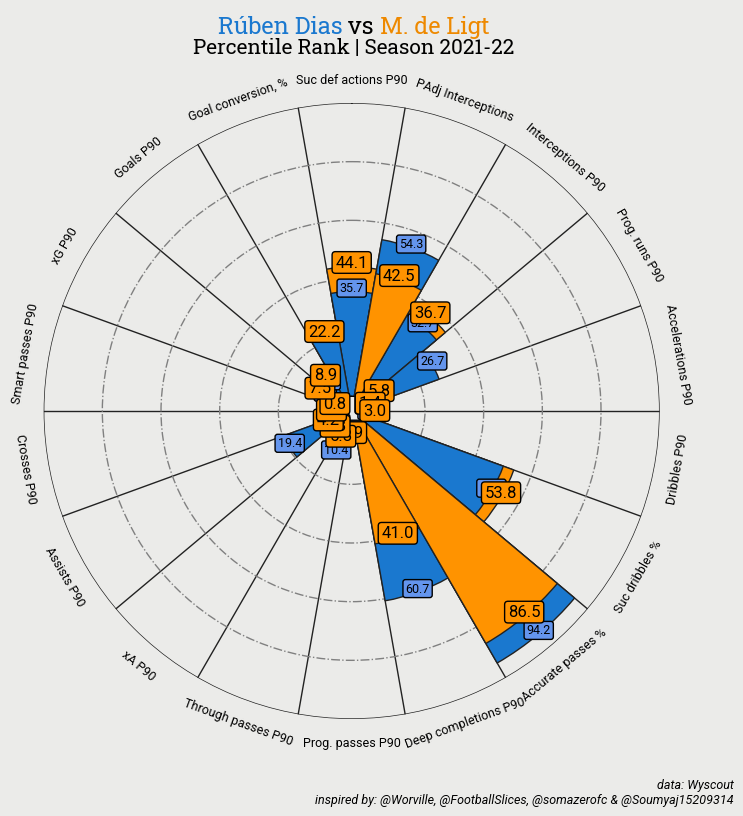

In [140]:
# Select two players to compare
player1 = metrics.loc[metrics['Player']==player_df.Player.iloc[0]].reset_index()
player2 = metrics.loc[metrics['Player']==player_df.Player.iloc[1]].reset_index()

# parameter list
params = [
    "Suc def actions P90", "PAdj Interceptions", "Interceptions P90",
    "Prog. runs P90", "Accelerations P90", "Dribbles P90", "Suc dribbles %",
    "Accurate passes %", "Deep completions P90", "Prog. passes P90", "Through passes P90",
    "xA P90", "Assists P90", "Crosses P90", "Smart passes P90",
    "xG P90", "Goals P90", "Goal conversion, %"
]

# value list
values = [
    round(player1['Successful defensive actions per 90'].loc[0],1),round(player1['PAdj Interceptions'].loc[0],1),round(player1['Interceptions per 90'].loc[0],1),
    round(player1['Progressive runs per 90'].loc[0],1), round(player1['Accelerations per 90'].loc[0],1), round(player1['Dribbles per 90'].loc[0],1), round(player1['Successful dribbles, %'].loc[0],1),
    round(player1['Accurate passes, %'].loc[0],1), round(player1['Progressive passes per 90'].loc[0],1), round(player1['Deep completions per 90'].loc[0],1), round(player1['Through passes per 90'].loc[0],1),
    round(player1['xA per 90'].loc[0],1), round(player1['Assists per 90'].loc[0],1), round(player1['Crosses per 90'].loc[0],1), round(player1['Smart passes per 90'].loc[0],1),
    round(player1['xG per 90'].loc[0],1), round(player1['Goals per 90'].loc[0],1),round(player1['Goal conversion, %'].loc[0],1)
]
values_2 = [
    round(player2['Successful defensive actions per 90'].loc[0],1),round(player2['PAdj Interceptions'].loc[0],1),round(player2['Interceptions per 90'].loc[0],1),
    round(player2['Progressive runs per 90'].loc[0],1), round(player2['Accelerations per 90'].loc[0],1), round(player2['Dribbles per 90'].loc[0],1), round(player2['Successful dribbles, %'].loc[0],1),
    round(player2['Accurate passes, %'].loc[0],1), round(player2['Progressive passes per 90'].loc[0],1), round(player2['Deep completions per 90'].loc[0],1), round(player2['Through passes per 90'].loc[0],1),
    round(player2['xA per 90'].loc[0],1), round(player2['Assists per 90'].loc[0],1), round(player2['Crosses per 90'].loc[0],1), round(player2['Smart passes per 90'].loc[0],1),
    round(player2['xG per 90'].loc[0],1), round(player2['Goals per 90'].loc[0],1), round(player1['Goal conversion, %'].loc[0],1)
]

# instantiate PyPizza class
baker = PyPizza(
    params=params,                  # list of parameters
    background_color="#EBEBE9",     # background color
    straight_line_color="#222222",  # color for straight lines
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    last_circle_color="#222222",    # color of last circle
    other_circle_ls="-.",           # linestyle for other circles
    other_circle_lw=1               # linewidth for other circles
)

# plot pizza
fig, ax = baker.make_pizza(
    values,                     # list of values
    compare_values=values_2,    # comparison values
    figsize=(8, 8),             # adjust figsize according to your need
    kwargs_slices=dict(
        facecolor="#1A78CF", edgecolor="#222222",
        zorder=2, linewidth=1
    ),                          # values to be used when plotting slices
    kwargs_compare=dict(
        facecolor="#FF9300", edgecolor="#222222",
        zorder=2, linewidth=1,
    ),
    kwargs_params=dict(
        color="#000000", fontsize=9,
        fontproperties=font_normal.prop, va="center"
    ),                          # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=9,
        fontproperties=font_normal.prop, zorder=3,
        bbox=dict(
            edgecolor="#000000", facecolor="cornflowerblue",
            boxstyle="round,pad=0.2", lw=1
        )
    ),                          # values to be used when adding parameter-values labels
    kwargs_compare_values=dict(
        color="#000000", fontsize=12, fontproperties=font_normal.prop, zorder=3,
        bbox=dict(edgecolor="#000000", facecolor="#FF9300", boxstyle="round,pad=0.2", lw=1)
    ),                          # values to be used when adding parameter-values labels
)

# add title
fig_text(
    0.515, 0.99, f"<{player_df.Player.iloc[0]}> vs <{player_df.Player.iloc[1]}>", size=17, fig=fig,
    highlight_textprops=[{"color": '#1A78CF'}, {"color": '#EE8900'}],
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add subtitle
fig.text(
    0.515, 0.942,
    "Percentile Rank | Season 2021-22",
    size=15,
    ha="center", fontproperties=font_bold.prop, color="#000000"
)

# add credits
CREDIT_1 = "data: Wyscout"
CREDIT_2 = "inspired by: @Worville, @FootballSlices, @somazerofc & @Soumyaj15209314"

fig.text(
    0.99, 0.005, f"{CREDIT_1}\n{CREDIT_2}", size=9,
    fontproperties=font_italic.prop, color="#000000",
    ha="right"
)

plt.show()